In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as inte
from astropy import units as u
from astropy import constants as const

In [39]:
#constants and units
H0 = 67.9 * u.km/u.s/u.Mpc
c = const.c
G = const.G.to(u.km**2 * u.Mpc /u.Msun/u.s**2)
chirpM = 26*u.Msun
rho_crit = (3/8/np.pi) * H0**2 /G # has dimensions of density (mass/volume)

fref = 25. /u.s
OmegaGW_limit = 4.8e-8
Rate = 53.2 /(u.Gpc**3 * u.year)
t_obs = 1.5 *u.year

m_min = 6.7 * u.Msun
m_max = 41.9 * u.Msun
gamma = -1.4

## Horizon Distance of a Euclidian Universe 

$$ r_{\text{hor}} = \frac{9 H_0 c^3}{8 N} (G \pi \mathcal{M})^{-5/3} \Omega_{\text{ref}}f_{\text{ref}} ^{-2/3} $$ 

Where $N$ is the number density of events. Here we have assumed it to be the local merger rate $R$ times the time it has taken light to reach us from the horizon distance $t= r_{hor}/c$. 

In [25]:
def r_hor(H0,c,G,Mchirp,Omega,fref,R):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0 *(c**4)
    
    rhor_2 = (9/(8 * R)) * Hoc * GpiM53 * Omegaf
    return np.sqrt(rhor_2)

In [47]:
r = r_hor(H0,c,G,chirpM,OmegaGW_limit,fref,Rate)
r.to(u.Gpc)

<Quantity 19.667974968147806 Gpc>

In [ ]:
hubble_dist = c/H0
(r/hubble_dist).to(u.m/u.m)

In [8]:
#chirp mass for two 30 solar mass BHs
m = 30 * u.Msun
M53 = m*m*(m+m)**(-1/3)
M53**(3/5)

<Quantity 26.1165169 solMass>

In [26]:
# if you want to integrate over observing time instead of the age of the U
def r_hor_tobs(H0,c,G,Mchirp,Omega,fref,R,tobs):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    GpiM53 = np.power(G*np.pi*Mchirp,-5./3)
    Hoc = H0 *(c**3)
    N = R * tobs
    
    rhor = (9./(8 *N)) * Hoc * GpiM53 * Omegaf
    return rhor

In [21]:
r = r_hor_tobs(H0,c,G,chirpM,OmegaGW_limit,fref,Rate,t_obs)
r.to(u.Gpc)

<Quantity 841112156663.8446 Gpc>

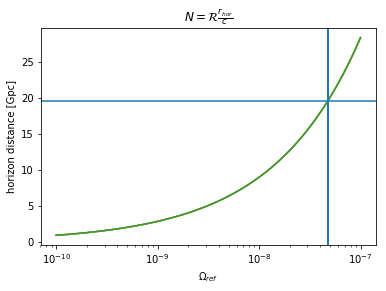

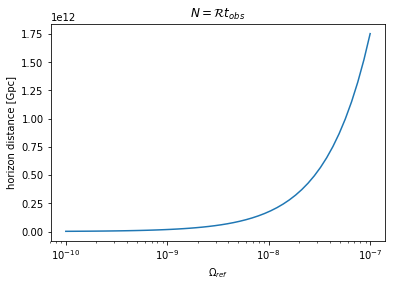

In [49]:
#plot them
possible_omegas = np.logspace(-10,-7)
# --- t= age of U ---#
plt.plot(possible_omegas,r_hor(H0,c,G,chirpM,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit)
plt.axhline(19.6)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'$N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()
#--- t = t_obs ---#
plt.plot(possible_omegas,r_hor_tobs(H0,c,G,chirpM,possible_omegas,fref,Rate,t_obs).to(u.Gpc))
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'$N = \mathcal{R}t_{obs}$')
plt.show()

### Adding in a mass distribution

In [96]:
#this assumes equal masses and a power law for each component mass
def r_hor_marg_Mchirp(H0,c,G,Omega,fref,R0):
    '''calculates the horizon distance assuming a euclidian static universe.
    Inputs must all have astropy units.'''
    Omegaf = Omega*np.power(fref,-2./3)
    Gpi53 = np.power(np.pi,-5./3)
    Hoc = H0 * (c**4)
    
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power))    
    RofM = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max*G,5./3)-np.power(m_min,power)*np.power(m_min*G,5./3)) \
    / (power+5./3)
    #(you have to do some finegling to get the 5/3 thing to cancel units with the mass in G properly but this does the trick^)
    
    rhor_2 = (9./(8 *RofM)) * Hoc * Gpi53 * Omegaf
    return np.sqrt(rhor_2)

In [97]:
r_hor_marg_Mchirp(H0,c,G,OmegaGW_limit,fref,Rate).to(u.Gpc)

<Quantity 39.199123838245484 Gpc>

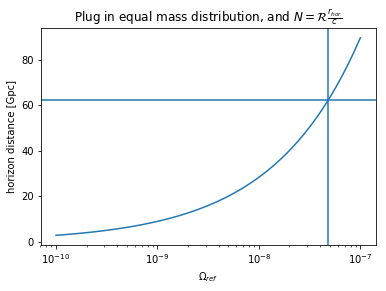

In [95]:
plt.plot(possible_omegas,r_hor_marg_Mchirp(H0,c,G,possible_omegas,fref,Rate).to(u.Gpc))
plt.axvline(OmegaGW_limit)
plt.axhline(62.22473)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\Omega_{ref}$')
plt.ylabel('horizon distance [Gpc]')
plt.title(r'Plug in equal mass distribution, and $N = \mathcal{R}\frac{r_{hor}}{c}$')
plt.show()

## Putting Limits on FLRW parameters

$ \rho_c c^2 \Omega_{GW} (f) = \frac{(f \pi G)^{2/3}}{3} \int_0^{z_f} \frac{\mathrm{d}z}{(1+z)^{1/3} H(z)} \text{(massfac)} $

where $ \text{massfac} = \int_0^\infty \text{d}\mathcal{M} \frac{\text{d}\mathcal{R}(\mathcal{M},z)}{\text{d}\mathcal{M}} \mathcal{M}^{5/3}$ accounts for the mass distribution of binaries

In [29]:
def massfac(R0,gamma,m_min,m_max):
    '''lets again assume the equal masses model that does not evolve in redshift 
    (eventually we will want to evolve it in redshift so that zf has an astrophysical rather that cosmological meaning)
    '''
    prefac = R0/(2**(1./3))
    power = (2 * gamma + 1)
    norm = power /(np.power(m_max,power) - np.power(m_min,power)) 
    massfac = norm * prefac \
    * (np.power(m_max,power)*np.power(m_max,5./3)-np.power(m_min,power)*np.power(m_min,5./3)) \
    / (power+5./3)
    return massfac

def int_over_z(z,Omega_m,Omega_Lam,Omega_r,Omega_k):
    H_z = np.sqrt(Omega_Lam + Omega_r * (1 + z)**4. + Omega_m * (1 + z)**3. + Omega_k * (1 + z)**2. )
    integrand = 1./((1+z)*H_z)
    return integrand

def OmegaGW(zf,Omega_m,fref):
    fpiG = np.power(fref*np.pi*G,2./3)/3.
    rhoc2 = ( c**2 ) * ( H0**2 ) * 3 /( 8 * np.pi * G )
    mfac = massfac(Rate,gamma,m_min,m_max)
    integral = inte.quad(int_over_z,0,zf,args=(Omega_m, 0.3,0,0))[0]
    integral *= 1./H0
    
    return (integral * mfac * fpiG / rhoc2).to(u.m/u.m)

In [44]:
#define arrays for evaluating
zf_array = np.linspace(0.1, 10,num=50)
Omega_m_array = np.linspace(0,1.4,num=50)
Omega_gw_z_free = np.zeros(len(zf_array))
Omega_gw_Omegam_free = np.zeros(len(Omega_m_array))

#test
OmegaGW(1000,0.3,fref)

<Quantity 6.53255328356069e-10>

In [46]:
#have to do it with a loop because of how inte.quad works
for i in range(len(zf_array)):
    Omega_gw_z_free[i]= OmegaGW(zf_array[i],0.3,fref)
    Omega_gw_Omegam_free[i] = OmegaGW(6.,Omega_m_array[i],fref)

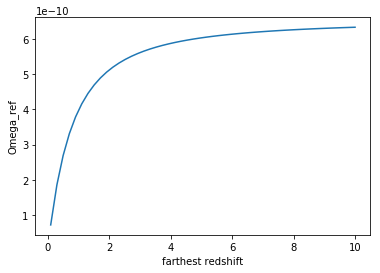

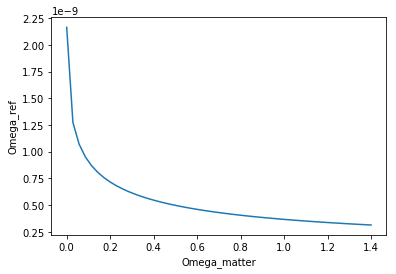

In [47]:
plt.plot(zf_array,Omega_gw_z_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('farthest redshift')
plt.ylabel('Omega_ref')
plt.show()

plt.plot(Omega_m_array,Omega_gw_Omegam_free)
#plt.axhline(OmegaGW_limit)
plt.xlabel('Omega_matter')
plt.ylabel('Omega_ref')
plt.show()